In [1]:
import numpy as np
import scvelo as scv
import pandas as pd
import loompy
import glob
import os
from scipy import io
%matplotlib inline
import matplotlib.pylab as plt
import scanpy as sc

In [4]:
cell_df_subset = pd.read_csv(
    '/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat_2/5_sample/meta_data.csv'
).set_index('Row.names')

In [6]:
pca_subset =  pd.read_csv(
    '/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat_2/5_sample/pca.csv'
)

In [7]:
pca_subset.index = cell_df_subset.index

In [16]:
def build_subset_objects(loom_file,count_dir):
    X = io.mmread(
        os.path.join(
            count_dir,
            'counts.mtx'
        )
    )
    
    gene_file = os.path.join(
        count_dir,
        'genes.csv'
    )

    with open(gene_file, 'r') as f:
        gene_names = f.read().splitlines()
        
    cell_file = os.path.join(
        count_dir,
        'cell_names.csv'
    )

    with open(cell_file, 'r') as f:
        cell_names = f.read().splitlines()
        
    adata = sc.AnnData(
        X=X.transpose().tocsr()
    )
    
    adata.obs = pd.DataFrame(index = cell_names[1:])
    adata.var.index = gene_names
    
    cell_subset = set(cell_names[1:]).intersection(set(cell_df_subset.index))
    adata = adata[list(cell_subset),]
    adata.obsm['X_umap'] = \
    cell_df_subset.loc[adata.obs.index][['UMAP_1','UMAP_2']].values
    adata.obsm['X_pca'] = pca_subset.loc[adata.obs.index].to_numpy()
    
    loom_data = scv.read(loom_file)
    gene_list = \
    loom_data.var.index.str.split('_').str[1].tolist()[:-1] + ['MYCN']
    loom_data.var.index = gene_list
    
    obs = loom_data.obs.copy()
    obs['aux_pre'] = obs.index.str.split(':').str[0]
    obs['cell_barcode'] = obs.index.str.split(':').str[1].str[:-1]
    obs['cell_id'] = obs.aux_pre + '_' + obs.cell_barcode + '-1'
    loom_data.obs.index = obs.cell_id.values
    
    adata_merged = scv.utils.merge(adata, loom_data)
    
    return adata_merged

In [8]:
loom_data = scv.read('/d0-bayes/home/meisl/neuroblastoma/ThMYCN_210610/Files/het1_tumor/outs/velocyto/het1_tumor.loom')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
adata_subset_dict = {}
samples = ['het1_tumor' ,'het2_tumor',  'homo1_tumor',  'homo2_tumor',  'homo3_tumor']
for s in samples:
    adata = build_subset_objects(
        '/d0-bayes/home/meisl/neuroblastoma/ThMYCN_210610/Files/{}/outs/velocyto/{}.loom'.format(s,s),
        '/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat_2/5_sample_raw_counts/{}'.format(s)
    )
    adata_subset_dict[s] = adata.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [22]:
cell_df_subset

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,integrated_snn_res.0.5,seurat_clusters,integrated_snn_res.0.3,annot,adrn_score1,UMAP_1,UMAP_2
Row.names,,,,,,,,,,,
het1_tumor_AAACCCAAGCTTTCCC-1,het1,4684,2393,3.810926,2,9,9,Sympathoblasts 4,0.224730,-4.732944,-5.993383
het1_tumor_AAACCCAAGGCGTTAG-1,het1,4041,2175,4.574907,1,1,1,Sympathoblasts 1,0.423461,2.654133,-1.637898
het1_tumor_AAACCCACAATCTCGA-1,het1,2337,1365,2.419355,12,22,22,Endothelial,0.097429,2.033597,-13.040475
het1_tumor_AAACCCACACCAAAGG-1,het1,5719,2817,4.676617,2,9,9,Sympathoblasts 4,0.514374,-4.856750,-4.991664
het1_tumor_AAACCCAGTCGAACAG-1,het1,4549,2283,5.868777,0,6,6,Sympathoblasts 1,0.229519,1.441997,-4.008420
...,...,...,...,...,...,...,...,...,...,...,...
homo3_tumor_TTTGTTGGTCATCAGT-1,homo3,3039,1652,0.102067,5,16,16,Sympathoblasts 2,-0.125257,4.405778,6.025249
homo3_tumor_TTTGTTGGTCCAGGTC-1,homo3,3387,1883,3.053931,4,0,0,Sympathoblasts 6,0.038373,4.565839,0.006426
homo3_tumor_TTTGTTGGTCCGTACG-1,homo3,11674,4235,4.643216,2,3,3,Sympathoblasts 4,0.504160,-2.431335,-5.195459


In [23]:
for s in samples:
    adata_subset_dict[s].obs['clusters'] = \
        pd.Categorical(cell_df_subset.loc[adata_subset_dict[s].obs.index, 'annot'])

In [24]:
for s in samples: 
    scv.pp.filter_and_normalize(
        adata_subset_dict[s], 
        min_shared_counts=20, 
        n_top_genes=2000
    )
    
    scv.tl.velocity(
    adata_subset_dict[s], 
    mode='stochastic'
    )
    scv.tl.velocity_graph(
        adata_subset_dict[s],
        n_jobs=30
    )    

Filtered out 23345 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:17) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 30/56 cores)


  0%|          | 0/12856 [00:00<?, ?cells/s]

    finished (0:00:17) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Filtered out 22706 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 30/56 cores)


  0%|          | 0/6833 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Filtered out 23899 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 30/56 cores)


  0%|          | 0/6860 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Filtered out 22358 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 30/56 cores)


  0%|          | 0/4058 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Filtered out 23892 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 30/56 cores)


  0%|          | 0/11725 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [26]:
code_dict = pd.read_csv(
    os.path.join(
             '/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat_2/5_sample/',
            'color_code.csv'
    )
).set_index('ind')[['code']].to_dict()['code']

In [27]:
code_dict

{'B cells': '#F8766D',
 'Chromaffin': '#E68613',
 'Endothelial': '#CD9600',
 'Immature ADRN': '#ABA300',
 'mDC': '#7CAE00',
 'Mesenchymal': '#0CB702',
 'Myeloid': '#00BE67',
 'Neutrophils': '#00C19A',
 'pDC': '#00BFC4',
 'Sympathoblasts 1': '#00B8E7',
 'Sympathoblasts 2': '#00A9FF',
 'Sympathoblasts 3': '#8494FF',
 'Sympathoblasts 4': '#C77CFF',
 'Sympathoblasts 5': '#ED68ED',
 'Sympathoblasts 6': '#FF61CC',
 'T cells': '#FF68A1'}

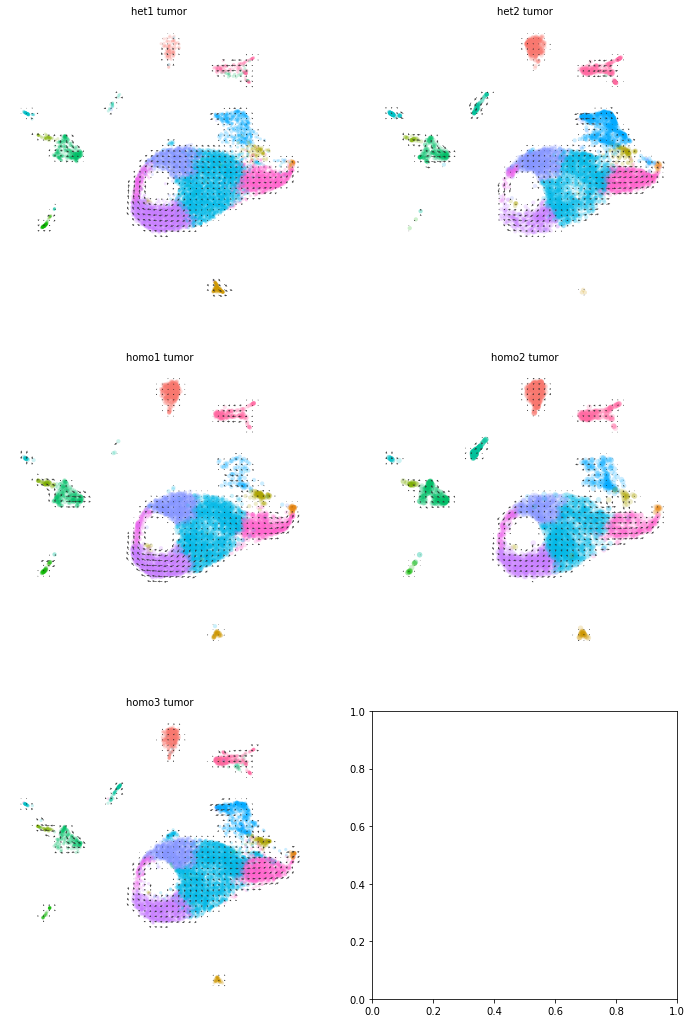

In [31]:
fig, ax = plt.subplots(3,2,figsize=(12,18))

for i in range(5):
    r = int(i / 2)
    c = i % 2
    #print(r,c)
    scv.pl.velocity_embedding_grid(
        adata_subset_dict[samples[i]], 
        basis='umap', 
        palette = [code_dict[c] for c in adata_subset_dict[samples[i]].obs.clusters.cat.categories],
        title=samples[i], 
        scale=0.8,
        ax = ax[r,c],
        show = False
    )
    
plt.show()

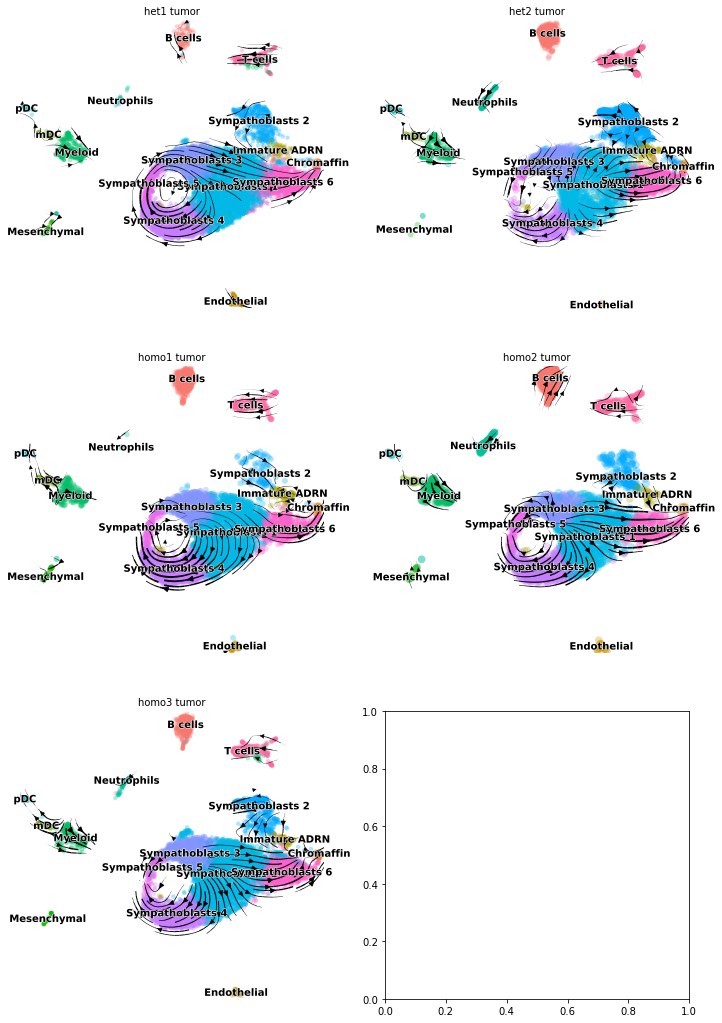

In [30]:
fig, ax = plt.subplots(3,2,figsize=(12,18))

for i in range(5):
    r = int(i / 2)
    c = i % 2
    #print(r,c)
    scv.pl.velocity_embedding_stream(
        adata_subset_dict[samples[i]],
        legend_loc='on data', 
        title=samples[i],
        #palette = [code_dict[c] for c in adata_subset_dict[samples[i]].obs.clusters.cat.categories],
        basis='umap', 
        dpi=300,
        ax = ax[r,c],
        show = False
    )
    
plt.show()